# Transfer learning traffic sign classifier

## 0. General

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

## 1. Load data

In [2]:
import pickle

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Combine together since we are going to create train/val/test sets after VGG looks at it
# Is that bad?

X, y = np.append(train['features'], test['features'], axis=0), np.append(train['labels'], test['labels'])
#X_test, y_test = test['features'], test['labels']

#X = X[:2000]
#y = y[:2000]
print(X.shape, y.shape)

(47429, 32, 32, 3) (47429,)


5


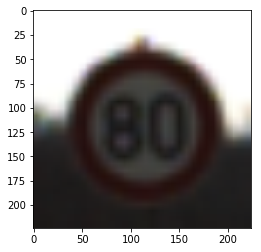

In [3]:
import random
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(1, len(X))
image = X[index].squeeze()
image = scipy.misc.imresize(image, [224, 224])
plt.imshow(image)
print(y[index])

### 1.2 Classes

In [4]:
from pandas.io.parsers import read_csv
classes = read_csv("signnames.csv").values[:, 1]
print(classes)

['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road' 'Slippery road'
 'Road narrows on the right' 'Road work' 'Traffic signals' 'Pedestrians'
 'Children crossing' 'Bicycles crossing' 'Beware of ice/snow'
 'Wild animals crossing' 'End of all speed and passing limits'
 'Turn right ahead' 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vehicles over 3.5 metric tons']


### 2. Pre train with VGG

In [5]:
batch_size = 64
codes_list = []
labels = []
batch = np.empty([0, 224, 224, 3])
codes = None

In [ ]:
#tf.reset_default_graph()

with tf.Session() as sess:
    my_vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    
    with tf.name_scope("content_vgg"):
        my_vgg.build(input_)
    
    len_ = len(X)
    for i, image in enumerate(X):
        image = scipy.misc.imresize(image, [224, 224])
        batch = np.append(batch, [image], axis=0)
        # print(batch.shape)
        
        labels.append(y[i])

        # Running the batch through the network to get the codes
        if i % batch_size == 0 or i == len_ - 1:

            # Get the values from the relu6 layer of the VGG network
            feed_dict = {input_ : batch}
            print(batch.shape)

            # KEY!!!!            
            codes_batch = sess.run(my_vgg.relu6, feed_dict = feed_dict)

            # Here I'm building an array of the codes
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            # Reset to start building the next batch
            batch = np.empty([0, 224, 224, 3])
            print('{:.2f} % of images processed'.format(i/len(X)*100))

In [7]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)  

In [8]:
print(codes.shape, y.shape)

(51839, 4096) (51839,)


### 3. Classifier

In [9]:
# read codes and labels from file
import csv

with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(y), -1))

    print(codes.shape)

(51839, 4096)


###  Validation set

In [10]:
from sklearn.preprocessing import LabelBinarizer

labelBinarizer = LabelBinarizer()
labelBinarizer.fit(y)
labels_vecs = labelBinarizer.transform(y)
print(labels_vecs.shape)

(51839, 43)


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2)
i, j = next( sss.split(codes, y) )
h = len(j) // 2
j, k = j[:h], j[h: ]   # Validation 50%
# end j at half of j and start k at half of j

train_x, train_y = codes[i], labels_vecs[i]
val_x, val_y = codes[j], labels_vecs[j]
test_x, test_y =  codes[k], labels_vecs[k]

In [12]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (41471, 4096) (41471, 43)
Validation shapes (x, y): (5184, 4096) (5184, 43)
Test shapes (x, y): (5184, 4096) (5184, 43)


### Batches!


In [13]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Classifier layers

In [14]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, 43])

l_1 = tf.contrib.layers.fully_connected(inputs_, 4096)

#drop_out = tf.nn.dropout(l_1, .2)

# Add tf.image.adjust_brightness etc. here
    
logits = tf.contrib.layers.fully_connected(l_1, 43, activation_fn=None)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, 
                                                        logits=logits)

cost = tf.reduce_mean( cross_entropy )

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## 4. Training

In [15]:
saver = tf.train.Saver()

In [16]:
e = 100
iteration = 0

with tf.Session() as sess:
    
    # 1. Start session
    sess.run(tf.global_variables_initializer() )
    
    # 2. Do each epoch
    for i in range(e):
        
        #3. Do each batch
        for j, k in get_batches(train_x, train_y):
            
            #4. Input data
            feed = {inputs_: j, labels_: k}
                        
            #5. Do loss
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            #6. Increment counter 
            iteration += 1
            
            #7. Print results
            print("Epoch: {} / {}".format( i, e),
                 "Iteration: {}".format( iteration ),
                 "Train loss: {:.7f}".format( loss ))
            
            #8. Do Validation
            if iteration % 5 == 0:
                feed = {inputs_: val_x, labels_: val_y}
            
                val_acc = sess.run(accuracy, feed_dict=feed)
                
                print("Epoch: {} / {}".format( i, e),
                 "Iteration: {} ".format( iteration),
                 "Validation Acc: {:.5f}".format(val_acc) )
        
    saver.save(sess, "checkpoints/a.ckpt")

Epoch: 0 / 100 Iteration: 1 Train loss: 1379.8046875
Epoch: 0 / 100 Iteration: 2 Train loss: 4765.2509766
Epoch: 0 / 100 Iteration: 3 Train loss: 6956.6860352
Epoch: 0 / 100 Iteration: 4 Train loss: 8813.9082031
Epoch: 0 / 100 Iteration: 5 Train loss: 9791.2363281
Epoch: 0 / 100 Iteration: 5  Validation Acc: 0.23476
Epoch: 0 / 100 Iteration: 6 Train loss: 10283.0888672
Epoch: 0 / 100 Iteration: 7 Train loss: 10644.9296875
Epoch: 0 / 100 Iteration: 8 Train loss: 10572.6826172
Epoch: 0 / 100 Iteration: 9 Train loss: 9830.2187500
Epoch: 0 / 100 Iteration: 10 Train loss: 8850.6611328
Epoch: 0 / 100 Iteration: 10  Validation Acc: 0.27932
Epoch: 1 / 100 Iteration: 11 Train loss: 7628.3881836
Epoch: 1 / 100 Iteration: 12 Train loss: 6372.3486328
Epoch: 1 / 100 Iteration: 13 Train loss: 5940.6425781
Epoch: 1 / 100 Iteration: 14 Train loss: 5759.1464844
Epoch: 1 / 100 Iteration: 15 Train loss: 4661.9814453
Epoch: 1 / 100 Iteration: 15  Validation Acc: 0.40818
Epoch: 1 / 100 Iteration: 16 Train 

Epoch: 13 / 100 Iteration: 131 Train loss: 1.1322412
Epoch: 13 / 100 Iteration: 132 Train loss: 1.2993309
Epoch: 13 / 100 Iteration: 133 Train loss: 1.1438552
Epoch: 13 / 100 Iteration: 134 Train loss: 1.1119069
Epoch: 13 / 100 Iteration: 135 Train loss: 0.8431520
Epoch: 13 / 100 Iteration: 135  Validation Acc: 0.90258
Epoch: 13 / 100 Iteration: 136 Train loss: 1.0814648
Epoch: 13 / 100 Iteration: 137 Train loss: 0.9997476
Epoch: 13 / 100 Iteration: 138 Train loss: 0.9442377
Epoch: 13 / 100 Iteration: 139 Train loss: 0.8671349
Epoch: 13 / 100 Iteration: 140 Train loss: 0.7588915
Epoch: 13 / 100 Iteration: 140  Validation Acc: 0.90066
Epoch: 14 / 100 Iteration: 141 Train loss: 0.9529404
Epoch: 14 / 100 Iteration: 142 Train loss: 1.1787919
Epoch: 14 / 100 Iteration: 143 Train loss: 1.0239868
Epoch: 14 / 100 Iteration: 144 Train loss: 0.9087358
Epoch: 14 / 100 Iteration: 145 Train loss: 0.6828351
Epoch: 14 / 100 Iteration: 145  Validation Acc: 0.90606
Epoch: 14 / 100 Iteration: 146 Train 

Epoch: 25 / 100 Iteration: 260 Train loss: 0.3856362
Epoch: 25 / 100 Iteration: 260  Validation Acc: 0.91744
Epoch: 26 / 100 Iteration: 261 Train loss: 0.7436368
Epoch: 26 / 100 Iteration: 262 Train loss: 0.4346994
Epoch: 26 / 100 Iteration: 263 Train loss: 0.3175412
Epoch: 26 / 100 Iteration: 264 Train loss: 0.1919069
Epoch: 26 / 100 Iteration: 265 Train loss: 0.1403967
Epoch: 26 / 100 Iteration: 265  Validation Acc: 0.91917
Epoch: 26 / 100 Iteration: 266 Train loss: 0.3505985
Epoch: 26 / 100 Iteration: 267 Train loss: 0.4945488
Epoch: 26 / 100 Iteration: 268 Train loss: 0.3363181
Epoch: 26 / 100 Iteration: 269 Train loss: 0.1886283
Epoch: 26 / 100 Iteration: 270 Train loss: 0.1308864
Epoch: 26 / 100 Iteration: 270  Validation Acc: 0.92014
Epoch: 27 / 100 Iteration: 271 Train loss: 0.2337095
Epoch: 27 / 100 Iteration: 272 Train loss: 0.3400331
Epoch: 27 / 100 Iteration: 273 Train loss: 0.2962362
Epoch: 27 / 100 Iteration: 274 Train loss: 0.2373891
Epoch: 27 / 100 Iteration: 275 Train 

Epoch: 38 / 100 Iteration: 389 Train loss: 0.0163779
Epoch: 38 / 100 Iteration: 390 Train loss: 0.0159192
Epoch: 38 / 100 Iteration: 390  Validation Acc: 0.92593
Epoch: 39 / 100 Iteration: 391 Train loss: 0.0188030
Epoch: 39 / 100 Iteration: 392 Train loss: 0.0152235
Epoch: 39 / 100 Iteration: 393 Train loss: 0.0375277
Epoch: 39 / 100 Iteration: 394 Train loss: 0.0137831
Epoch: 39 / 100 Iteration: 395 Train loss: 0.0200944
Epoch: 39 / 100 Iteration: 395  Validation Acc: 0.92612
Epoch: 39 / 100 Iteration: 396 Train loss: 0.0078138
Epoch: 39 / 100 Iteration: 397 Train loss: 0.0229488
Epoch: 39 / 100 Iteration: 398 Train loss: 0.0128847
Epoch: 39 / 100 Iteration: 399 Train loss: 0.0141142
Epoch: 39 / 100 Iteration: 400 Train loss: 0.0130800
Epoch: 39 / 100 Iteration: 400  Validation Acc: 0.92631
Epoch: 40 / 100 Iteration: 401 Train loss: 0.0176305
Epoch: 40 / 100 Iteration: 402 Train loss: 0.0137677
Epoch: 40 / 100 Iteration: 403 Train loss: 0.0355160
Epoch: 40 / 100 Iteration: 404 Train 

Epoch: 51 / 100 Iteration: 517 Train loss: 0.0068533
Epoch: 51 / 100 Iteration: 518 Train loss: 0.0050857
Epoch: 51 / 100 Iteration: 519 Train loss: 0.0040131
Epoch: 51 / 100 Iteration: 520 Train loss: 0.0019890
Epoch: 51 / 100 Iteration: 520  Validation Acc: 0.92785
Epoch: 52 / 100 Iteration: 521 Train loss: 0.0060130
Epoch: 52 / 100 Iteration: 522 Train loss: 0.0049325
Epoch: 52 / 100 Iteration: 523 Train loss: 0.0166577
Epoch: 52 / 100 Iteration: 524 Train loss: 0.0025061
Epoch: 52 / 100 Iteration: 525 Train loss: 0.0062339
Epoch: 52 / 100 Iteration: 525  Validation Acc: 0.92785
Epoch: 52 / 100 Iteration: 526 Train loss: 0.0011427
Epoch: 52 / 100 Iteration: 527 Train loss: 0.0065077
Epoch: 52 / 100 Iteration: 528 Train loss: 0.0046752
Epoch: 52 / 100 Iteration: 529 Train loss: 0.0036379
Epoch: 52 / 100 Iteration: 530 Train loss: 0.0018404
Epoch: 52 / 100 Iteration: 530  Validation Acc: 0.92785
Epoch: 53 / 100 Iteration: 531 Train loss: 0.0056057
Epoch: 53 / 100 Iteration: 532 Train 

Epoch: 64 / 100 Iteration: 645  Validation Acc: 0.92805
Epoch: 64 / 100 Iteration: 646 Train loss: 0.0006528
Epoch: 64 / 100 Iteration: 647 Train loss: 0.0023913
Epoch: 64 / 100 Iteration: 648 Train loss: 0.0020322
Epoch: 64 / 100 Iteration: 649 Train loss: 0.0011187
Epoch: 64 / 100 Iteration: 650 Train loss: 0.0008912
Epoch: 64 / 100 Iteration: 650  Validation Acc: 0.92785
Epoch: 65 / 100 Iteration: 651 Train loss: 0.0020516
Epoch: 65 / 100 Iteration: 652 Train loss: 0.0013896
Epoch: 65 / 100 Iteration: 653 Train loss: 0.0082936
Epoch: 65 / 100 Iteration: 654 Train loss: 0.0011964
Epoch: 65 / 100 Iteration: 655 Train loss: 0.0021345
Epoch: 65 / 100 Iteration: 655  Validation Acc: 0.92785
Epoch: 65 / 100 Iteration: 656 Train loss: 0.0006277
Epoch: 65 / 100 Iteration: 657 Train loss: 0.0020493
Epoch: 65 / 100 Iteration: 658 Train loss: 0.0019766
Epoch: 65 / 100 Iteration: 659 Train loss: 0.0010343
Epoch: 65 / 100 Iteration: 660 Train loss: 0.0008536
Epoch: 65 / 100 Iteration: 660  Valid

Epoch: 77 / 100 Iteration: 774 Train loss: 0.0007696
Epoch: 77 / 100 Iteration: 775 Train loss: 0.0005744
Epoch: 77 / 100 Iteration: 775  Validation Acc: 0.92766
Epoch: 77 / 100 Iteration: 776 Train loss: 0.0004538
Epoch: 77 / 100 Iteration: 777 Train loss: 0.0005587
Epoch: 77 / 100 Iteration: 778 Train loss: 0.0014881
Epoch: 77 / 100 Iteration: 779 Train loss: 0.0005744
Epoch: 77 / 100 Iteration: 780 Train loss: 0.0005352
Epoch: 77 / 100 Iteration: 780  Validation Acc: 0.92766
Epoch: 78 / 100 Iteration: 781 Train loss: 0.0009150
Epoch: 78 / 100 Iteration: 782 Train loss: 0.0007714
Epoch: 78 / 100 Iteration: 783 Train loss: 0.0012649
Epoch: 78 / 100 Iteration: 784 Train loss: 0.0007491
Epoch: 78 / 100 Iteration: 785 Train loss: 0.0005236
Epoch: 78 / 100 Iteration: 785  Validation Acc: 0.92766
Epoch: 78 / 100 Iteration: 786 Train loss: 0.0004528
Epoch: 78 / 100 Iteration: 787 Train loss: 0.0005418
Epoch: 78 / 100 Iteration: 788 Train loss: 0.0014532
Epoch: 78 / 100 Iteration: 789 Train 

Epoch: 90 / 100 Iteration: 902 Train loss: 0.0005101
Epoch: 90 / 100 Iteration: 903 Train loss: 0.0003505
Epoch: 90 / 100 Iteration: 904 Train loss: 0.0005312
Epoch: 90 / 100 Iteration: 905 Train loss: 0.0002741
Epoch: 90 / 100 Iteration: 905  Validation Acc: 0.92805
Epoch: 90 / 100 Iteration: 906 Train loss: 0.0002919
Epoch: 90 / 100 Iteration: 907 Train loss: 0.0003516
Epoch: 90 / 100 Iteration: 908 Train loss: 0.0010912
Epoch: 90 / 100 Iteration: 909 Train loss: 0.0003946
Epoch: 90 / 100 Iteration: 910 Train loss: 0.0003713
Epoch: 90 / 100 Iteration: 910  Validation Acc: 0.92785
Epoch: 91 / 100 Iteration: 911 Train loss: 0.0005965
Epoch: 91 / 100 Iteration: 912 Train loss: 0.0004970
Epoch: 91 / 100 Iteration: 913 Train loss: 0.0003394
Epoch: 91 / 100 Iteration: 914 Train loss: 0.0005189
Epoch: 91 / 100 Iteration: 915 Train loss: 0.0002647
Epoch: 91 / 100 Iteration: 915  Validation Acc: 0.92785
Epoch: 91 / 100 Iteration: 916 Train loss: 0.0002838
Epoch: 91 / 100 Iteration: 917 Train 

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [17]:
# 94% with 100 - 200 epochs  no other changes

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\a.ckpt
Test accuracy: 0.9271


In [18]:
# 89% with 300 epochs dropout

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\a.ckpt
Test accuracy: 0.9271


In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

In [20]:
# Run this cell if you don't have a vgg graph built
if 'my_vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [21]:
#test_img_path = 'flower_photos/daisy/5547758_eea9edfd54_n.jpg'
#test_img = imread(test_img_path)
#plt.imshow(test_img)

INFO:tensorflow:Restoring parameters from checkpoints\a.ckpt


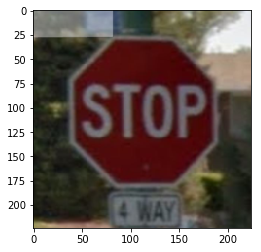

In [22]:
with tf.Session() as sess:
    #image = X[2000]
    
    #plt.imshow(image)
    
    image = scipy.misc.imread('extra-images/' + "1.jpg")
    
    image = scipy.misc.imresize(image, [224, 224])
    
    plt.imshow(image)
    
    image = image.reshape((1, 224, 224, 3))


    feed_dict = {input_: image}
    
    ## KEY
    code = sess.run(my_vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()
    
    top5 = sess.run(tf.nn.top_k(tf.constant(prediction), k=5, sorted=True))
    
    # print(prediction)

In [23]:
print(top5)
print(max(prediction))

for i in range(5):
    print(classes[top5.indices[i]])

TopKV2(values=array([ 1.,  0.,  0.,  0.,  0.], dtype=float32), indices=array([14,  0,  1,  2,  3]))
1.0
Stop
Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)


[1.0, 0.0, 0.0, 0.0, 0.0]


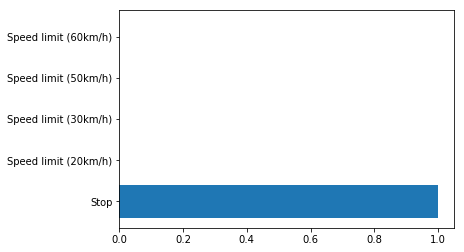

In [24]:
#print(max(prediction))

chart_i = [i for i in classes[top5.indices]]
chart_v = [i for i in top5.values]
print(chart_v)

plt.barh(np.arange(5), chart_v)

_ = plt.yticks(np.arange(5), chart_i)